In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

#ignoring all warnings
import warnings
warnings.filterwarnings('ignore')

import shap

# load JS visualization code to notebook. Without this, the SHAP plots won't be displayed
shap.initjs()

Here, we try to use Explainable AI (XAI) tools to explain the inner workings of a machine learning model. ML models are known to be sort of black boxes, but with XAI, one can have some sense of how the model comes about its predictions.

Here, we work with a dataset on patients to predict breast cancer diagnosis.

About the dataset:

Different features related to the breast are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe the characteristics of the cell nuclei present in the image.

* id: Id number

* diagnosis: Cancer is Malignant or Benign (M = malignant, B = benign) - target variable

The other 20 features contain information about the following 10 real value features

* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values)
* perimeter
* area
* smoothness (local variation in radius lengths)
* compactness (perimeter^2 / area - 1.0)
* concavity (severity of concave portions of the contour)
* concave points (number of concave portions of the contour)
* symmetry
* fractal dimension ("coastline approximation" - 1)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/breast_cancer/Training_set_breastcancer.csv')

In [ ]:
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,914102,13.16,20.54,84.06,538.7,0.07335,0.05275,0.01800,0.01256,0.1713,...,28.46,95.29,648.3,0.1118,0.1646,0.07698,0.04195,0.2687,0.07429,B
1,91858,11.75,17.56,75.89,422.9,0.10730,0.09713,0.05282,0.04440,0.1598,...,27.98,88.52,552.3,0.1349,0.1854,0.13660,0.10100,0.2478,0.07757,B
2,88466802,10.65,25.22,68.01,347.0,0.09657,0.07234,0.02379,0.01615,0.1897,...,35.19,77.98,455.7,0.1499,0.1398,0.11250,0.06136,0.3409,0.08147,B
3,9111843,12.00,28.23,76.77,442.5,0.08437,0.06450,0.04055,0.01945,0.1615,...,37.88,85.07,523.7,0.1208,0.1856,0.18110,0.07116,0.2447,0.08194,B
4,84862001,16.13,20.68,108.10,798.8,0.11700,0.20220,0.17220,0.10280,0.2164,...,31.48,136.80,1315.0,0.1789,0.4233,0.47840,0.20730,0.3706,0.11420,M


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       398 non-null    int64  
 1   radius_mean              398 non-null    float64
 2   texture_mean             398 non-null    float64
 3   perimeter_mean           398 non-null    float64
 4   area_mean                398 non-null    float64
 5   smoothness_mean          398 non-null    float64
 6   compactness_mean         398 non-null    float64
 7   concavity_mean           398 non-null    float64
 8   concave points_mean      398 non-null    float64
 9   symmetry_mean            398 non-null    float64
 10  fractal_dimension_mean   398 non-null    float64
 11  radius_se                398 non-null    float64
 12  texture_se               398 non-null    float64
 13  perimeter_se             398 non-null    float64
 14  area_se                  3

# Exploratory Data Analysis (EDA)

In [ ]:
df.diagnosis.value_counts()

B    250
M    148
Name: diagnosis, dtype: int64

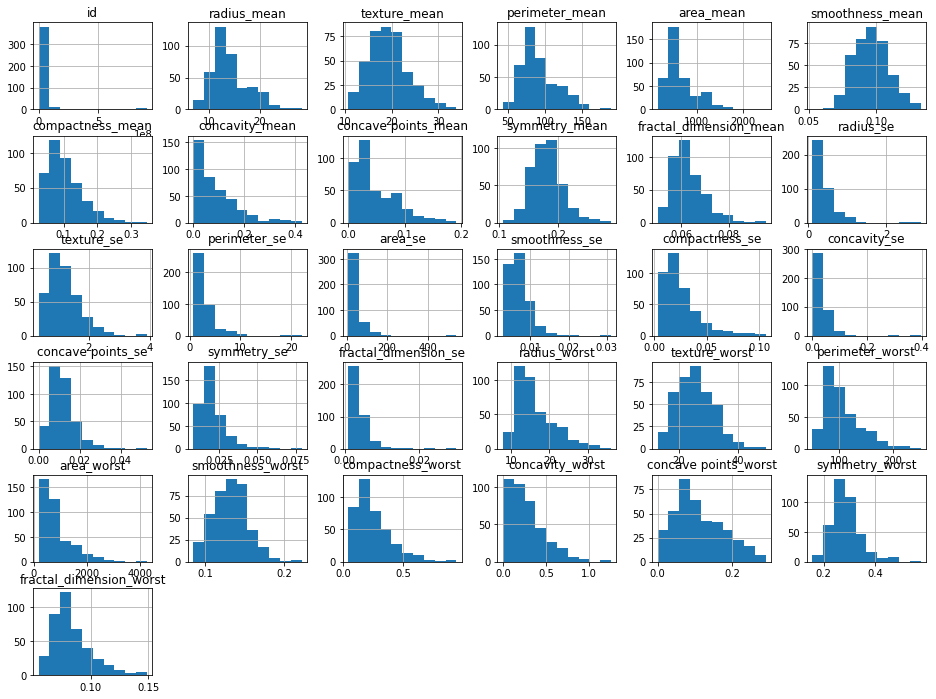

In [ ]:
df.hist(bins=10, figsize=(16,12))
plt.show()

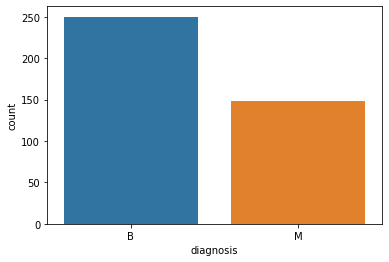

In [ ]:
sns.countplot(x='diagnosis', data=df);

There are more B diagnosis than M diagnosis, but we have a balanced data

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,398.0,3.076209e+07,1.277890e+08,8913.000000,867475.000000,905529.500000,8.812818e+06,9.113205e+08
radius_mean,398.0,1.407100e+01,3.577839e+00,6.981000,11.645000,13.205000,1.574500e+01,2.811000e+01
texture_mean,398.0,1.933198e+01,4.221225e+00,10.720000,16.172500,18.895000,2.166000e+01,3.381000e+01
perimeter_mean,398.0,9.158912e+01,2.470639e+01,43.790000,74.690000,85.660000,1.037000e+02,1.885000e+02
area_mean,398.0,6.516319e+02,3.586792e+02,143.500000,415.375000,538.300000,7.803250e+02,2.501000e+03
smoothness_mean,398.0,9.628884e-02,1.298821e-02,0.052630,0.086635,0.096515,1.053000e-01,1.326000e-01
compactness_mean,398.0,1.031975e-01,5.080500e-02,0.026500,0.066013,0.095090,1.295500e-01,3.454000e-01
concavity_mean,398.0,8.745403e-02,7.972786e-02,0.000000,0.028010,0.059935,1.266750e-01,4.264000e-01
concave points_mean,398.0,4.782106e-02,3.832949e-02,0.000000,0.019787,0.033420,6.828250e-02,1.913000e-01
symmetry_mean,398.0,1.811221e-01,2.682936e-02,0.106000,0.161650,0.179300,1.956750e-01,2.906000e-01


In [ ]:
df.diagnosis = df.diagnosis.apply(lambda x: 1 if x == 'M' else 0)

In [ ]:
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,914102,13.16,20.54,84.06,538.7,0.07335,0.05275,0.01800,0.01256,0.1713,...,28.46,95.29,648.3,0.1118,0.1646,0.07698,0.04195,0.2687,0.07429,0
1,91858,11.75,17.56,75.89,422.9,0.10730,0.09713,0.05282,0.04440,0.1598,...,27.98,88.52,552.3,0.1349,0.1854,0.13660,0.10100,0.2478,0.07757,0
2,88466802,10.65,25.22,68.01,347.0,0.09657,0.07234,0.02379,0.01615,0.1897,...,35.19,77.98,455.7,0.1499,0.1398,0.11250,0.06136,0.3409,0.08147,0
3,9111843,12.00,28.23,76.77,442.5,0.08437,0.06450,0.04055,0.01945,0.1615,...,37.88,85.07,523.7,0.1208,0.1856,0.18110,0.07116,0.2447,0.08194,0
4,84862001,16.13,20.68,108.10,798.8,0.11700,0.20220,0.17220,0.10280,0.2164,...,31.48,136.80,1315.0,0.1789,0.4233,0.47840,0.20730,0.3706,0.11420,1


In [ ]:
df.corr()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
id,1.000000,0.053013,0.064714,0.053310,0.085935,-0.045771,-0.012110,0.053062,0.034495,-0.078422,...,0.041220,0.056923,0.098540,-0.007036,-0.009724,0.024639,0.020508,-0.093087,-0.023410,0.002175
radius_mean,0.053013,1.000000,0.370559,0.997984,0.986661,0.181021,0.531935,0.684128,0.833289,0.110827,...,0.329921,0.964768,0.939238,0.140573,0.466587,0.541233,0.754886,0.148066,0.014259,0.744796
texture_mean,0.064714,0.370559,1.000000,0.377602,0.371092,0.009188,0.283013,0.343909,0.347076,0.074819,...,0.909448,0.410636,0.400265,0.131954,0.306401,0.329708,0.333799,0.095071,0.135850,0.451652
perimeter_mean,0.053310,0.997984,0.377602,1.000000,0.986029,0.215509,0.580307,0.720764,0.859523,0.145323,...,0.337438,0.969863,0.939864,0.168529,0.505573,0.575270,0.779149,0.172585,0.055418,0.754676
area_mean,0.085935,0.986661,0.371092,0.986029,1.000000,0.185633,0.524159,0.696779,0.834096,0.115726,...,0.320911,0.958728,0.958249,0.141403,0.443660,0.528460,0.731554,0.127453,0.011020,0.721542
smoothness_mean,-0.045771,0.181021,0.009188,0.215509,0.185633,1.000000,0.633941,0.507177,0.536495,0.532225,...,0.080926,0.238416,0.206867,0.774433,0.450434,0.426570,0.481344,0.354264,0.457513,0.339341
compactness_mean,-0.012110,0.531935,0.283013,0.580307,0.524159,0.633941,1.000000,0.877536,0.832109,0.581543,...,0.292928,0.613184,0.533080,0.545285,0.866952,0.810001,0.808524,0.481947,0.659135,0.584091
concavity_mean,0.053062,0.684128,0.343909,0.720764,0.696779,0.507177,0.877536,1.000000,0.916765,0.474787,...,0.333262,0.730322,0.681134,0.440080,0.762450,0.885576,0.853648,0.388345,0.498175,0.674906
concave points_mean,0.034495,0.833289,0.347076,0.859523,0.834096,0.536495,0.832109,0.916765,1.000000,0.416276,...,0.337172,0.859342,0.814219,0.441862,0.687621,0.752165,0.905909,0.341613,0.347100,0.773784
symmetry_mean,-0.078422,0.110827,0.074819,0.145323,0.115726,0.532225,0.581543,0.474787,0.416276,1.000000,...,0.107975,0.179625,0.140769,0.385940,0.449289,0.418030,0.385992,0.695937,0.423496,0.280182


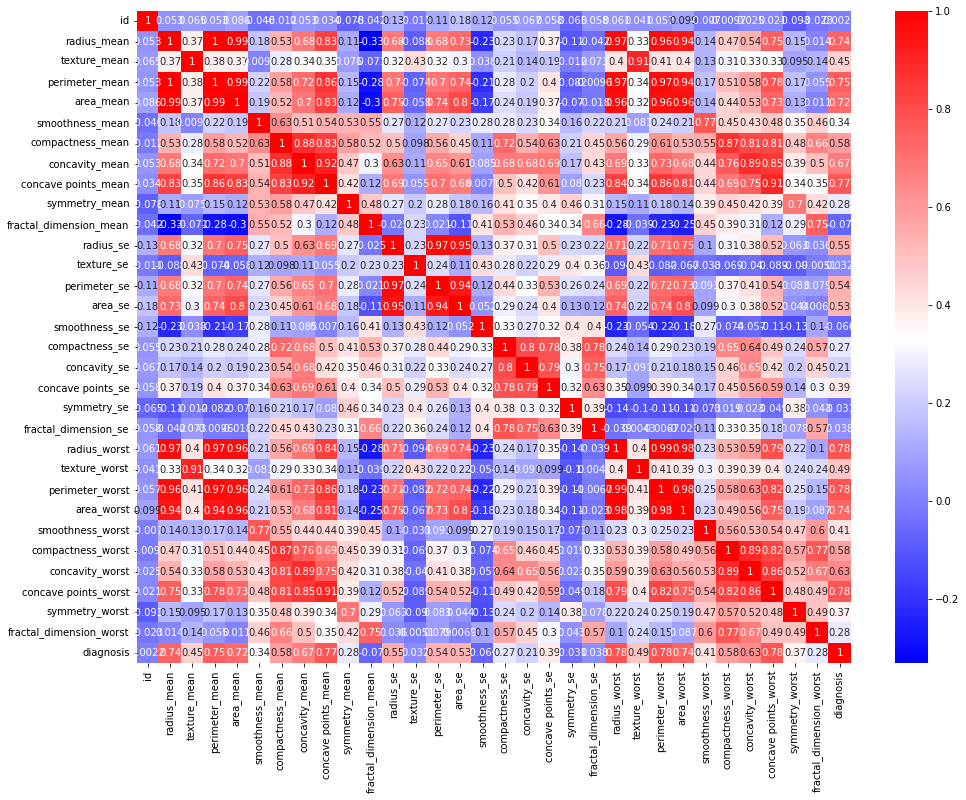

In [ ]:
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), cmap='bwr', annot=True);

In [ ]:
df.drop(['id'], axis = 1, inplace=True)

The id does not seem important, so we drop it

In [ ]:
df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,13.16,20.54,84.06,538.7,0.07335,0.05275,0.01800,0.01256,0.1713,0.05888,...,28.46,95.29,648.3,0.1118,0.1646,0.07698,0.04195,0.2687,0.07429,0
1,11.75,17.56,75.89,422.9,0.10730,0.09713,0.05282,0.04440,0.1598,0.06677,...,27.98,88.52,552.3,0.1349,0.1854,0.13660,0.10100,0.2478,0.07757,0
2,10.65,25.22,68.01,347.0,0.09657,0.07234,0.02379,0.01615,0.1897,0.06329,...,35.19,77.98,455.7,0.1499,0.1398,0.11250,0.06136,0.3409,0.08147,0
3,12.00,28.23,76.77,442.5,0.08437,0.06450,0.04055,0.01945,0.1615,0.06104,...,37.88,85.07,523.7,0.1208,0.1856,0.18110,0.07116,0.2447,0.08194,0
4,16.13,20.68,108.10,798.8,0.11700,0.20220,0.17220,0.10280,0.2164,0.07356,...,31.48,136.80,1315.0,0.1789,0.4233,0.47840,0.20730,0.3706,0.11420,1


In [ ]:
df1=df.copy()
df1.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,13.16,20.54,84.06,538.7,0.07335,0.05275,0.01800,0.01256,0.1713,0.05888,...,28.46,95.29,648.3,0.1118,0.1646,0.07698,0.04195,0.2687,0.07429,0
1,11.75,17.56,75.89,422.9,0.10730,0.09713,0.05282,0.04440,0.1598,0.06677,...,27.98,88.52,552.3,0.1349,0.1854,0.13660,0.10100,0.2478,0.07757,0
2,10.65,25.22,68.01,347.0,0.09657,0.07234,0.02379,0.01615,0.1897,0.06329,...,35.19,77.98,455.7,0.1499,0.1398,0.11250,0.06136,0.3409,0.08147,0
3,12.00,28.23,76.77,442.5,0.08437,0.06450,0.04055,0.01945,0.1615,0.06104,...,37.88,85.07,523.7,0.1208,0.1856,0.18110,0.07116,0.2447,0.08194,0
4,16.13,20.68,108.10,798.8,0.11700,0.20220,0.17220,0.10280,0.2164,0.07356,...,31.48,136.80,1315.0,0.1789,0.4233,0.47840,0.20730,0.3706,0.11420,1


In [ ]:
# We perform normalization to scale numerical data prior to modeling using Min-max scaling technique
cols=df1.columns

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df1[cols])
df1[cols] = scaler.transform(df1[cols])

df1.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,0.292442,0.425292,0.278281,0.167635,0.259097,0.082314,0.042214,0.065656,0.353738,0.194802,...,0.425143,0.223517,0.113817,0.195703,0.135620,0.061486,0.144158,0.266572,0.205750,0.0
1,0.225709,0.296232,0.221823,0.118515,0.683631,0.221480,0.123874,0.232096,0.291441,0.367111,...,0.412053,0.189800,0.090223,0.363386,0.158870,0.109105,0.347079,0.216916,0.240808,0.0
2,0.173648,0.627977,0.167369,0.086320,0.549456,0.143744,0.055793,0.084422,0.453413,0.291112,...,0.608672,0.137308,0.066482,0.472271,0.107899,0.089856,0.210859,0.438109,0.282493,0.0
3,0.237541,0.758337,0.227904,0.126829,0.396899,0.119160,0.095098,0.101673,0.300650,0.241974,...,0.682029,0.172618,0.083194,0.261034,0.159094,0.144649,0.244536,0.209551,0.287516,0.0
4,0.433007,0.431356,0.444406,0.277964,0.804927,0.550956,0.403846,0.537376,0.598050,0.515396,...,0.507499,0.430251,0.277674,0.682782,0.424790,0.382109,0.712371,0.508672,0.632322,1.0


Now, we split the data into Input and Target Variables, and then split further into train and test sets

In [ ]:
X = df1.drop(['diagnosis'], axis=1) # input variables
y = df1[['diagnosis']] # target variable

In [ ]:
X.shape

(398, 30)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Using XGBoost Model

In [ ]:
import xgboost as xgb #importing xgboost model from xgb library
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, random_state=0) # Creating a XGB Classifier

In [ ]:
xgc.fit(X_train, y_train) # Training the model with fit method

XGBClassifier(max_depth=5, n_estimators=500)

In [ ]:
predictions = xgc.predict(X_test)
predictions[:10]

array([1., 0., 1., 0., 0., 0., 0., 1., 1., 0.])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.9625

### SHAP

Here, we implement the XAI tool; SHAP to go through the inner workings of the model.

In [ ]:
# creating an explainer for our model
explainer = shap.TreeExplainer(xgc)

# finding out the shap values using the explainer
shap_values = explainer.shap_values(X_test)

# Expected/Base/Reference value = the value that would be predicted if we didn’t know any features of the current output”
print('Expected Value:', explainer.expected_value)

# displaying the first 5 rows of the shap values table
pd.DataFrame(shap_values).head()

Expected Value: -1.3128371


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.001297,0.941329,0.099106,-0.113331,0.142014,0.002438,0.408731,1.391267,-0.414416,-0.012649,...,-0.942178,1.128205,0.876195,0.579892,0.918326,0.005907,0.122367,1.647578,0.464622,0.123307
1,-0.006988,-0.759738,-0.112501,-0.226145,0.055512,0.000512,-0.194795,-0.898413,0.265540,-0.016283,...,-1.558191,0.044955,-0.865787,-0.509998,-0.211240,-0.007544,-0.124623,-0.386588,0.423580,-0.145808
2,-0.007646,-0.305943,-0.113148,-0.098635,0.061605,0.000351,-0.315543,-0.907825,0.481918,0.012844,...,3.960205,0.419505,1.003988,0.597430,0.731681,-0.002907,0.080922,-0.237714,0.445391,-0.058776
3,-0.006988,-0.872241,-0.115200,-0.226145,-0.069792,0.001142,-0.137840,-0.784715,0.491956,0.009268,...,-1.454704,-0.547366,-0.676024,-0.450923,-0.575040,-0.007544,-0.124623,-0.289371,-0.377372,-0.146458
4,-0.006988,-0.687501,-0.112501,-0.223022,-0.085861,0.001142,-0.138265,-0.825429,-0.414329,0.009268,...,-1.554214,-0.669540,-0.232769,-0.185044,-0.694752,-0.007544,-0.114928,-0.316357,0.474078,-0.146458


The Expected Value: -1.3128 will be used as the base value. That means the values above this base value will be put into class 1 (malignant diagnosis) and the values below it will be put into class 0 (benign diagnosis)

In [ ]:
shap_values

array([[-1.2974807e-03,  9.4132859e-01,  9.9105999e-02, ...,
         1.6475776e+00,  4.6462199e-01,  1.2330701e-01],
       [-6.9878036e-03, -7.5973779e-01, -1.1250109e-01, ...,
        -3.8658786e-01,  4.2357951e-01, -1.4580788e-01],
       [-7.6458515e-03, -3.0594301e-01, -1.1314834e-01, ...,
        -2.3771428e-01,  4.4539109e-01, -5.8776245e-02],
       ...,
       [ 5.9016116e-02,  6.7255867e-01,  1.0059182e-01, ...,
         8.4136891e-01,  4.5779502e-01, -6.2181135e-03],
       [ 5.9016116e-02, -9.3006566e-02,  1.0059182e-01, ...,
         6.9696659e-01, -4.5823777e-01, -5.9060935e-02],
       [-2.5907399e-02,  1.0369757e+00, -1.1250109e-01, ...,
        -4.3597418e-01, -4.4967622e-01, -4.9716134e-02]], dtype=float32)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[0,:], X_test.iloc[0,:])

Here, we understand that the first diagnosis in the test data is malignant, as was also seen when we inspected the first ten predictions of the model.

The red colour shows characteristics that push the shap value to the right for a potential malignant/positive diagnosis and the blue colour shows characteristics that push the shap value to the left for a potential benign/negative diagnosis

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[:,:], X_test.iloc[:,:])

* Most of the first 25 cases are predicted to be malignant and they have high radius worst values, concave points mean values, and perimeter worst values above 100. The radius worst values are mostly above 20.

* Most of the next 40 cases are diagnosed to be benign and they have much lower concave points mean values and perimeter worst values below 100. The radius worst values are mostly lower than 15.

* Most of the next 10+ cases are diagnosed to be malignant but not as intense as the first 25 cases. The perimeter worst values were above 100.

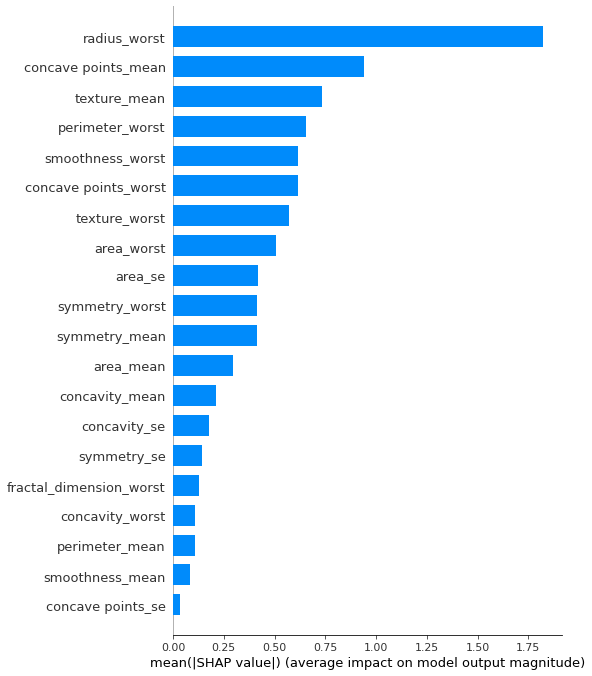

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, 
                  X_test, plot_type="bar")

Here, we see the features with the most impact on model prediction

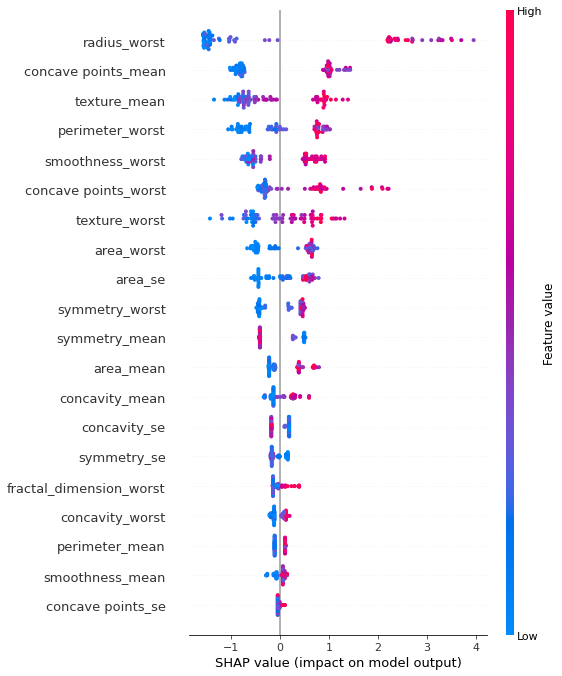

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

Here, we can see how much the different features impacted on the model output.

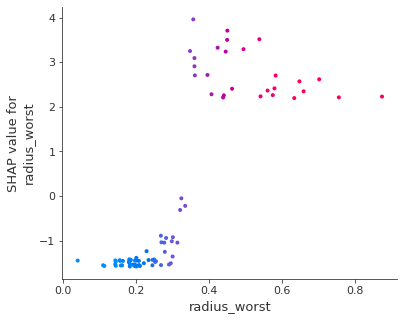

In [ ]:
shap.initjs()
shap.dependence_plot(ind='radius_worst', interaction_index='radius_worst',
                     shap_values=shap_values, 
                     features=X_test)

Here, we have a dependence plot that shows a positive correlation of the SHAP values for radius worst with the actual radius worst values. Higher radius worst values increase the chance of a malignant diagnosis. After a value of around 18, the radius worst values have a much strong effect on the malignance prediction from the model. 

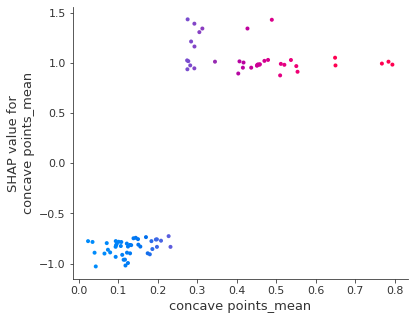

In [ ]:
shap.initjs()
shap.dependence_plot(ind='concave points_mean', interaction_index='concave points_mean',
                     shap_values=shap_values, 
                     features=X_test)

Higher concave points mean values increase the chance of a malignant diagnosis. After a value of around 0.24, the concave points mean values have a much strong effect on the malignance prediction from the model.



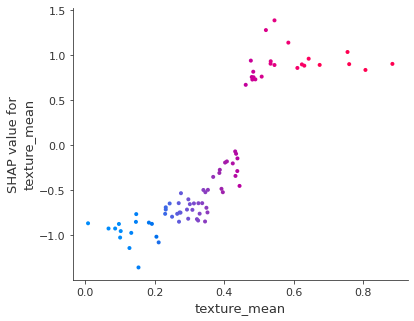

In [ ]:
shap.initjs()
shap.dependence_plot(ind='texture_mean', interaction_index='texture_mean',
                     shap_values=shap_values, 
                     features=X_test)

Here, we see a less sharp increase in SHAP values compared to the two other features shown above. Higher texture mean values also increase the chance of a malignant diagnosis. After a value of around 0.48, the texture mean values have a much strong effect on the malignance prediction from the model.

From the above plots and charts, we are able to give some explanation to how the prediction model utilize features in its diagnosis prediction.